# Homework #7 Answers

## Chongye Feng

In [1]:
# importing libraries
import numba
import numpy as np
import pandas as pd
from pylab import *
from mpl_toolkits.mplot3d import axes3d
from scipy.optimize import minimize

import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA

# setting the random seed
np.random.seed(0)

---

### Q1

In [2]:
import pickle


with open('mnist.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
len(data)

2

By checking the shape of the data set, I found that data[0] is the training set of the data, and data[0][0] is the train_x and data[0][1] is the train_y. data[1] is the test/validate set of the data, and data[1][0] is the test_x and data[1][1] is the test_y.

In [4]:
train_x, train_y, test_x, test_y = data[0][0], data[0][1], data[1][0], data[1][1]

In [5]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(12, 12),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(32, 32), cmap='binary')
        im.set_clim(0, 16)

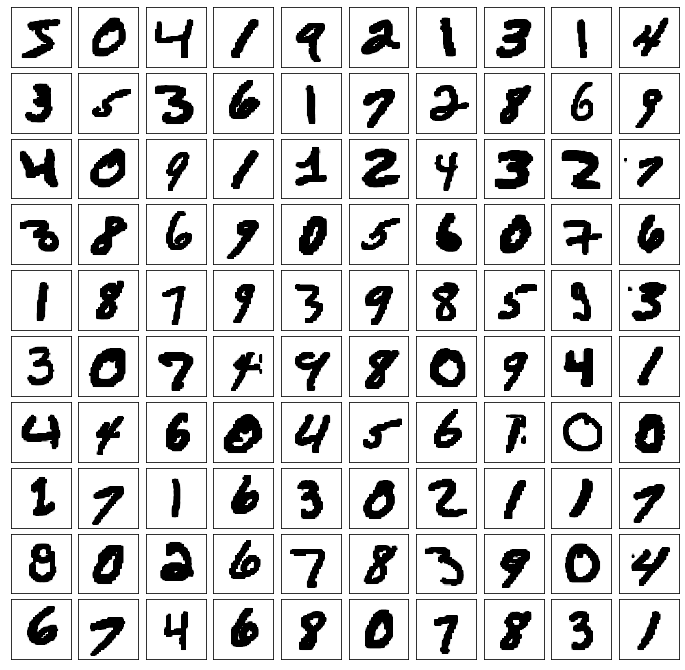

In [6]:
plot_digits(train_x)

#### a:

In [7]:
test_x[0].max()

255

In [8]:
train_x[0].max()

255

*Normalizing:*

In [9]:
train_x = train_x / 255

In [10]:
test_x  = test_x  / 255

In [11]:
train_x.max()

1.0

In [12]:
test_x.max()

1.0

#### b:

In [13]:
len(train_x)

60000

In [14]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [15]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

/Users/chongyefeng/opt/anaconda3/envs/msse-python/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
train_x = train_x.reshape((60000,-1))
test_x = test_x.reshape((10000,-1))
train_x.shape

(60000, 1024)

In [17]:
chunk_x = create_chunks(train_x, num_chunks=3)
chunk_y = create_chunks(train_y, num_chunks=3)

In [18]:
chunk_x[0].shape

(20000, 1024)

The **KFold** could be used in splitting the dataset into 3 folds, (2/3 and 1/3).

#### c:

In [19]:

class Trainer():
    def __init__(self, model, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        optimizer_type: 'adam' or 'sgd'
        learning_rate: float
        epoch: int
        batch_size: int
        input_transform: func
            transforming input. Can do reshape here
        """
        self.model = model
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
            
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform


    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.tensor(self.input_transform(inputs), dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        val_inputs = torch.tensor(self.input_transform(val_inputs), dtype=torch.float)
        val_outputs = torch.tensor(val_outputs, dtype=torch.int64)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model(batch_input)
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_lambda = 1e-5
                    l2_loss = sum([p.detach().pow(2.0).sum() for p in self.model.parameters()])
                    loss += l2_loss * l2_lambda
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.item() * batch_importance
                pred = torch.argmax(batch_predictions, axis = -1)
                acc = torch.mean((pred == batch_output).float()) # (T or F)
                epoch_acc += acc.detach().item() * batch_importance
                
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return {"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype=torch.float)
        outputs = torch.tensor(outputs, dtype=torch.int64)
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0
        losses = 0
        for batch in batch_indices:
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            with torch.no_grad():
                ### Compute prediction and loss###
                batch_predictions = self.model(batch_input)
                ### loss function of your choice ###
                loss = nn.CrossEntropyLoss()(batch_predictions, batch_output)
            pred = torch.argmax(batch_predictions, axis = -1)
            batch_acc = torch.mean((pred == batch_output).float())
            losses += loss.detach().item() * batch_importance
            acc += batch_acc.detach().item() * batch_importance
        
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [20]:
from torch import nn
import torch

class MLPNet_1C(nn.Module):
    def __init__(self):
        super(MLPNet_1C, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(1024, 3),
            nn.Linear(3, 10)])
        self.activation = nn.Sigmoid()
        
#         self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
            
#             x = self.dropout(x)
            
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.fc[-1](x))
        return x

In [21]:
model_1c = MLPNet_1C()

In [22]:
trainer_1c = Trainer(model=model_1c, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

In [23]:
#  def train(self, inputs, outputs, val_inputs, val_outputs,early_stop=False,l2=False,silent=False)
kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_1c = []
for train_index, val_index in kf.split(train_x, train_y):
    X_train, X_val = train_x[train_index], train_x[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_1c.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_results_1c.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:27,  1.78it/s]

Epoch 1/50 - Loss: 2.215 - Acc: 0.210
              Val_loss: 2.148 - Val_acc: 0.357


 22%|██▏       | 11/50 [00:03<00:12,  3.22it/s]

Epoch 11/50 - Loss: 1.790 - Acc: 0.608
              Val_loss: 1.791 - Val_acc: 0.580


 42%|████▏     | 21/50 [00:06<00:11,  2.47it/s]

Epoch 21/50 - Loss: 1.726 - Acc: 0.589
              Val_loss: 1.735 - Val_acc: 0.577


 62%|██████▏   | 31/50 [00:09<00:05,  3.52it/s]

Epoch 31/50 - Loss: 1.703 - Acc: 0.592
              Val_loss: 1.717 - Val_acc: 0.577


 82%|████████▏ | 41/50 [00:12<00:02,  3.57it/s]

Epoch 41/50 - Loss: 1.693 - Acc: 0.592
              Val_loss: 1.709 - Val_acc: 0.578


func:'train'  took: 15.3847 sec


  2%|▏         | 1/50 [00:00<00:23,  2.05it/s]

Epoch 1/50 - Loss: 1.695 - Acc: 0.584
              Val_loss: 1.689 - Val_acc: 0.591


 22%|██▏       | 11/50 [00:03<00:10,  3.60it/s]

Epoch 11/50 - Loss: 1.687 - Acc: 0.586
              Val_loss: 1.690 - Val_acc: 0.586


 42%|████▏     | 21/50 [00:06<00:08,  3.56it/s]

Epoch 21/50 - Loss: 1.683 - Acc: 0.587
              Val_loss: 1.691 - Val_acc: 0.583


 62%|██████▏   | 31/50 [00:08<00:05,  3.71it/s]

Epoch 31/50 - Loss: 1.680 - Acc: 0.587
              Val_loss: 1.690 - Val_acc: 0.581


 82%|████████▏ | 41/50 [00:11<00:02,  3.70it/s]

Epoch 41/50 - Loss: 1.678 - Acc: 0.587
              Val_loss: 1.691 - Val_acc: 0.577


func:'train'  took: 14.1387 sec


  2%|▏         | 1/50 [00:00<00:23,  2.06it/s]

Epoch 1/50 - Loss: 1.685 - Acc: 0.573
              Val_loss: 1.672 - Val_acc: 0.585


 22%|██▏       | 11/50 [00:03<00:10,  3.68it/s]

Epoch 11/50 - Loss: 1.680 - Acc: 0.558
              Val_loss: 1.677 - Val_acc: 0.562


 42%|████▏     | 21/50 [00:05<00:07,  3.70it/s]

Epoch 21/50 - Loss: 1.677 - Acc: 0.561
              Val_loss: 1.679 - Val_acc: 0.562


 62%|██████▏   | 31/50 [00:08<00:05,  3.73it/s]

Epoch 31/50 - Loss: 1.675 - Acc: 0.561
              Val_loss: 1.680 - Val_acc: 0.559


 82%|████████▏ | 41/50 [00:11<00:02,  3.67it/s]

Epoch 41/50 - Loss: 1.674 - Acc: 0.561
              Val_loss: 1.681 - Val_acc: 0.559


func:'train'  took: 14.0486 sec


#### d:

In [24]:
class MLPNet_1D(nn.Module):
    def __init__(self):
        super(MLPNet_1D, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(1024, 50),
            nn.Linear(50, 10)])
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
                        
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.fc[-1](x))
        return x
    
model_1d = MLPNet_1D()

In [25]:
trainer_1d = Trainer(model=model_1d, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_1d = []
for train_index, val_index in kf.split(train_x, train_y):
    X_train, X_val = train_x[train_index], train_x[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_1d.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_results_1d.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch 1/50 - Loss: 1.821 - Acc: 0.811
              Val_loss: 1.652 - Val_acc: 0.885


 22%|██▏       | 11/50 [00:06<00:20,  1.86it/s]

Epoch 11/50 - Loss: 1.509 - Acc: 0.954
              Val_loss: 1.520 - Val_acc: 0.943


 42%|████▏     | 21/50 [00:11<00:15,  1.85it/s]

Epoch 21/50 - Loss: 1.492 - Acc: 0.968
              Val_loss: 1.511 - Val_acc: 0.949


 62%|██████▏   | 31/50 [00:17<00:11,  1.72it/s]

Epoch 31/50 - Loss: 1.484 - Acc: 0.976
              Val_loss: 1.508 - Val_acc: 0.953


 82%|████████▏ | 41/50 [00:22<00:04,  1.82it/s]

Epoch 41/50 - Loss: 1.479 - Acc: 0.981
              Val_loss: 1.508 - Val_acc: 0.954


func:'train'  took: 27.8129 sec


  2%|▏         | 1/50 [00:00<00:37,  1.30it/s]

Epoch 1/50 - Loss: 1.491 - Acc: 0.969
              Val_loss: 1.479 - Val_acc: 0.982


 22%|██▏       | 11/50 [00:06<00:21,  1.84it/s]

Epoch 11/50 - Loss: 1.479 - Acc: 0.980
              Val_loss: 1.483 - Val_acc: 0.978


 42%|████▏     | 21/50 [00:11<00:15,  1.86it/s]

Epoch 21/50 - Loss: 1.475 - Acc: 0.983
              Val_loss: 1.486 - Val_acc: 0.977


 62%|██████▏   | 31/50 [00:17<00:10,  1.87it/s]

Epoch 31/50 - Loss: 1.473 - Acc: 0.985
              Val_loss: 1.489 - Val_acc: 0.974


 82%|████████▏ | 41/50 [00:22<00:04,  1.81it/s]

Epoch 41/50 - Loss: 1.472 - Acc: 0.986
              Val_loss: 1.491 - Val_acc: 0.974


func:'train'  took: 27.7777 sec


  2%|▏         | 1/50 [00:00<00:37,  1.31it/s]

Epoch 1/50 - Loss: 1.483 - Acc: 0.977
              Val_loss: 1.472 - Val_acc: 0.988


 22%|██▏       | 11/50 [00:06<00:20,  1.89it/s]

Epoch 11/50 - Loss: 1.474 - Acc: 0.984
              Val_loss: 1.472 - Val_acc: 0.988


 42%|████▏     | 21/50 [00:11<00:15,  1.84it/s]

Epoch 21/50 - Loss: 1.473 - Acc: 0.985
              Val_loss: 1.475 - Val_acc: 0.987


 62%|██████▏   | 31/50 [00:16<00:10,  1.86it/s]

Epoch 31/50 - Loss: 1.472 - Acc: 0.987
              Val_loss: 1.477 - Val_acc: 0.986


 82%|████████▏ | 41/50 [00:22<00:04,  1.86it/s]

Epoch 41/50 - Loss: 1.471 - Acc: 0.987
              Val_loss: 1.479 - Val_acc: 0.985


func:'train'  took: 27.3452 sec


#### c & d comparison:

The computational time for ANN-d, which has a hidden layer of size 50, is almost double that of ANN-c. This indicates that ANN-d is slower in terms of processing time compared to ANN-c.

In [26]:
trainer_1c.evaluate(test_x, test_y)

Accuracy: 0.550


(1.6903685411453255, 0.5501999999999999)

In [27]:
trainer_1d.evaluate(test_x, test_y)

Accuracy: 0.965


(1.5017577510833742, 0.9650000000000003)

We can see that the accuracy of d is better than c. 96.6% vs 75.4%

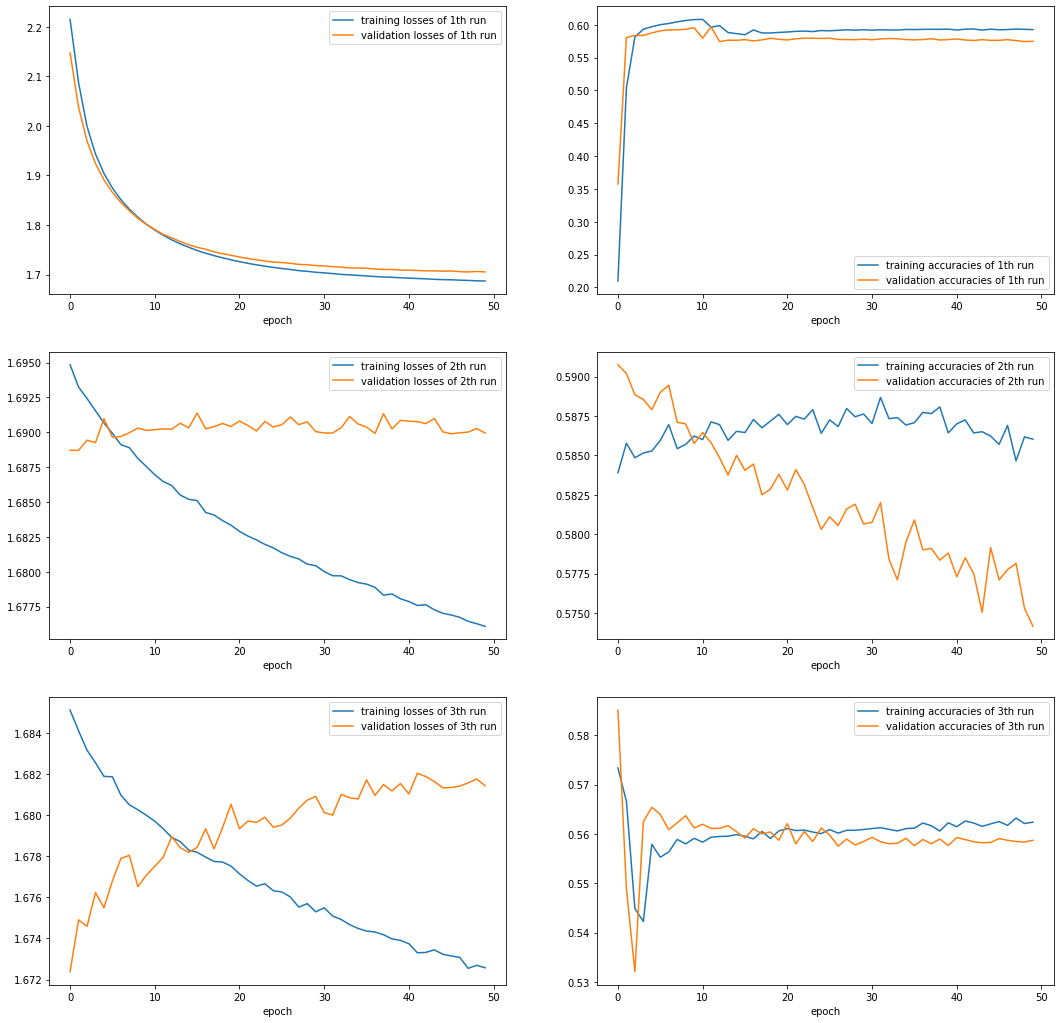

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_results_1c)):
    axes[i][0].plot(training_results_1c[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_results_1c[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_results_1c[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_results_1c[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

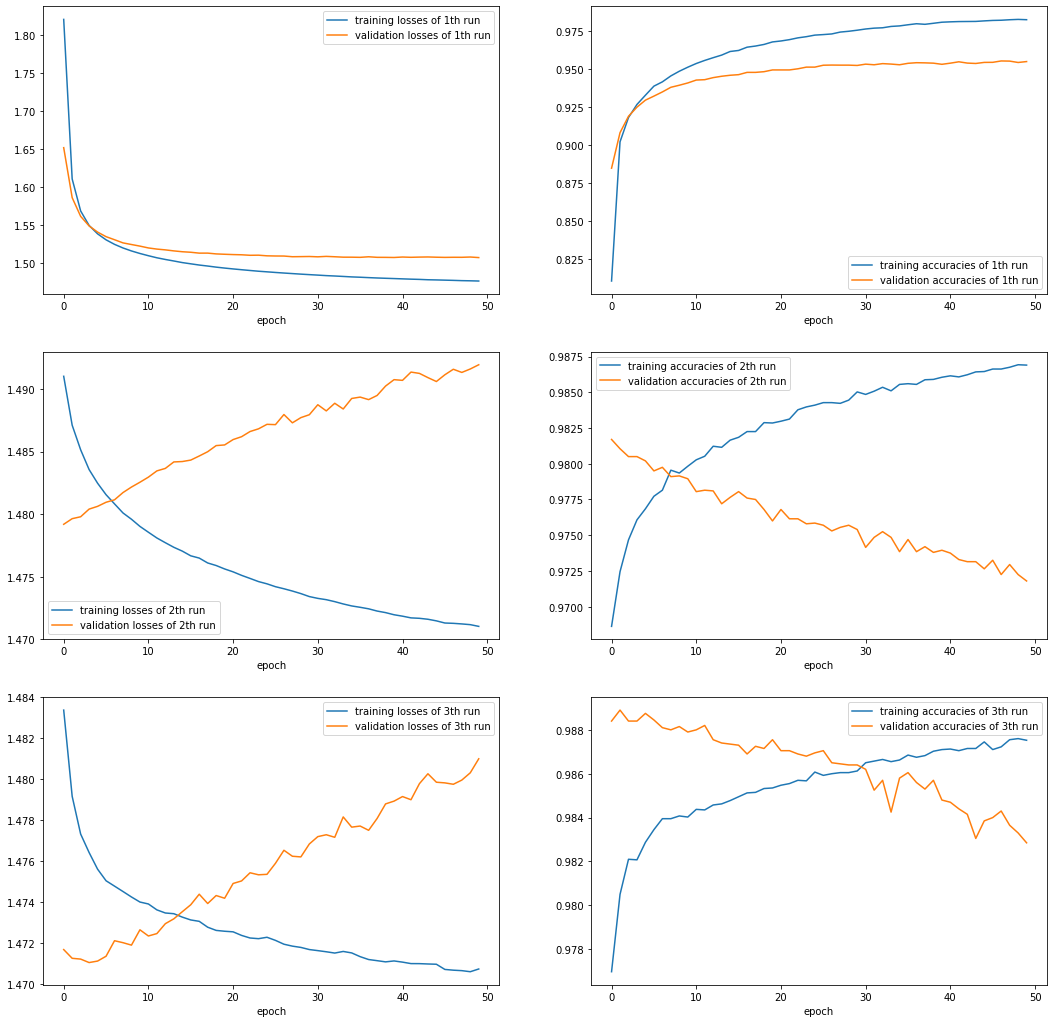

In [29]:
fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_results_1d)):
    axes[i][0].plot(training_results_1d[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_results_1d[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_results_1d[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_results_1d[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

ANN-1c has a small hidden layer of 3 neurons. As a result, it is underfitting at the 3rd run, and the accuracy is not improving as the training progresses. This is likely due to the limited capacity of the network to capture complex patterns in the data.

On the other hand, ANN-1d has a large hidden layer of 50 neurons. This can cause overfitting, which is evident in the 2nd and 3rd runs where the accuracy is decreasing as the training progresses. The network is likely memorizing the training data rather than generalizing to new examples.

Both ANN-1c and ANN-1d were trained with the same learning rate and number of epochs. It's possible that tuning these hyperparameters could improve the performance of both models.

To better visualize the performance of each ANN, I plotted their learning curves. The learning curve for ANN-1c shows that the validation accuracy at the 3rd run is low and not improving, indicating underfitting. The learning curve for ANN-1d, on the other hand, shows that the training accuracy is high but the validation accuracy is low and decreasing, indicating overfitting.

Overall, ANN-1c and ANN-1d have different strengths and weaknesses, and the choice of which one to use would depend on the specific task and dataset.

---

### 2:

#### a:

In [30]:
class MLPNet_2A(nn.Module):
    def __init__(self):
        super(MLPNet_2A, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(1024, 50),
            nn.Linear(50, 10)])
        self.activation = nn.Sigmoid()
        
        self.dropout = nn.Dropout(p=0.15)

    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
            
            x = self.dropout(x)
            
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.dropout(self.fc[-1](x)))
        return x
    
model_2a = MLPNet_2A()

In [31]:
trainer_2a = Trainer(model=model_2a, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_2a = []
for train_index, val_index in kf.split(train_x, train_y):
    X_train, X_val = train_x[train_index], train_x[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_2a.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_results_2a.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:42,  1.16it/s]

Epoch 1/50 - Loss: 1.906 - Acc: 0.730
              Val_loss: 1.667 - Val_acc: 0.888


 22%|██▏       | 11/50 [00:07<00:23,  1.65it/s]

Epoch 11/50 - Loss: 1.643 - Acc: 0.878
              Val_loss: 1.527 - Val_acc: 0.938


 42%|████▏     | 21/50 [00:13<00:17,  1.69it/s]

Epoch 21/50 - Loss: 1.633 - Acc: 0.886
              Val_loss: 1.517 - Val_acc: 0.945


 62%|██████▏   | 31/50 [00:19<00:10,  1.73it/s]

Epoch 31/50 - Loss: 1.625 - Acc: 0.894
              Val_loss: 1.513 - Val_acc: 0.947


 82%|████████▏ | 41/50 [00:26<00:06,  1.33it/s]

Epoch 41/50 - Loss: 1.623 - Acc: 0.896
              Val_loss: 1.510 - Val_acc: 0.948


func:'train'  took: 33.9410 sec


  2%|▏         | 1/50 [00:01<00:49,  1.02s/it]

Epoch 1/50 - Loss: 1.628 - Acc: 0.887
              Val_loss: 1.493 - Val_acc: 0.969


 22%|██▏       | 11/50 [00:09<00:34,  1.14it/s]

Epoch 11/50 - Loss: 1.625 - Acc: 0.892
              Val_loss: 1.495 - Val_acc: 0.966


 42%|████▏     | 21/50 [00:17<00:24,  1.17it/s]

Epoch 21/50 - Loss: 1.619 - Acc: 0.898
              Val_loss: 1.496 - Val_acc: 0.964


 62%|██████▏   | 31/50 [00:24<00:11,  1.61it/s]

Epoch 31/50 - Loss: 1.618 - Acc: 0.900
              Val_loss: 1.496 - Val_acc: 0.962


 82%|████████▏ | 41/50 [00:31<00:05,  1.55it/s]

Epoch 41/50 - Loss: 1.616 - Acc: 0.904
              Val_loss: 1.496 - Val_acc: 0.962


func:'train'  took: 36.7949 sec


  2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

Epoch 1/50 - Loss: 1.623 - Acc: 0.895
              Val_loss: 1.483 - Val_acc: 0.981


 22%|██▏       | 11/50 [00:06<00:22,  1.71it/s]

Epoch 11/50 - Loss: 1.620 - Acc: 0.898
              Val_loss: 1.485 - Val_acc: 0.977


 42%|████▏     | 21/50 [00:12<00:16,  1.71it/s]

Epoch 21/50 - Loss: 1.618 - Acc: 0.900
              Val_loss: 1.485 - Val_acc: 0.976


 62%|██████▏   | 31/50 [00:18<00:10,  1.76it/s]

Epoch 31/50 - Loss: 1.617 - Acc: 0.902
              Val_loss: 1.486 - Val_acc: 0.975


 82%|████████▏ | 41/50 [00:24<00:05,  1.72it/s]

Epoch 41/50 - Loss: 1.615 - Acc: 0.903
              Val_loss: 1.487 - Val_acc: 0.974


func:'train'  took: 30.1464 sec


Accuracy: 0.959
(1.4994068061828616, 0.9594000000000006)


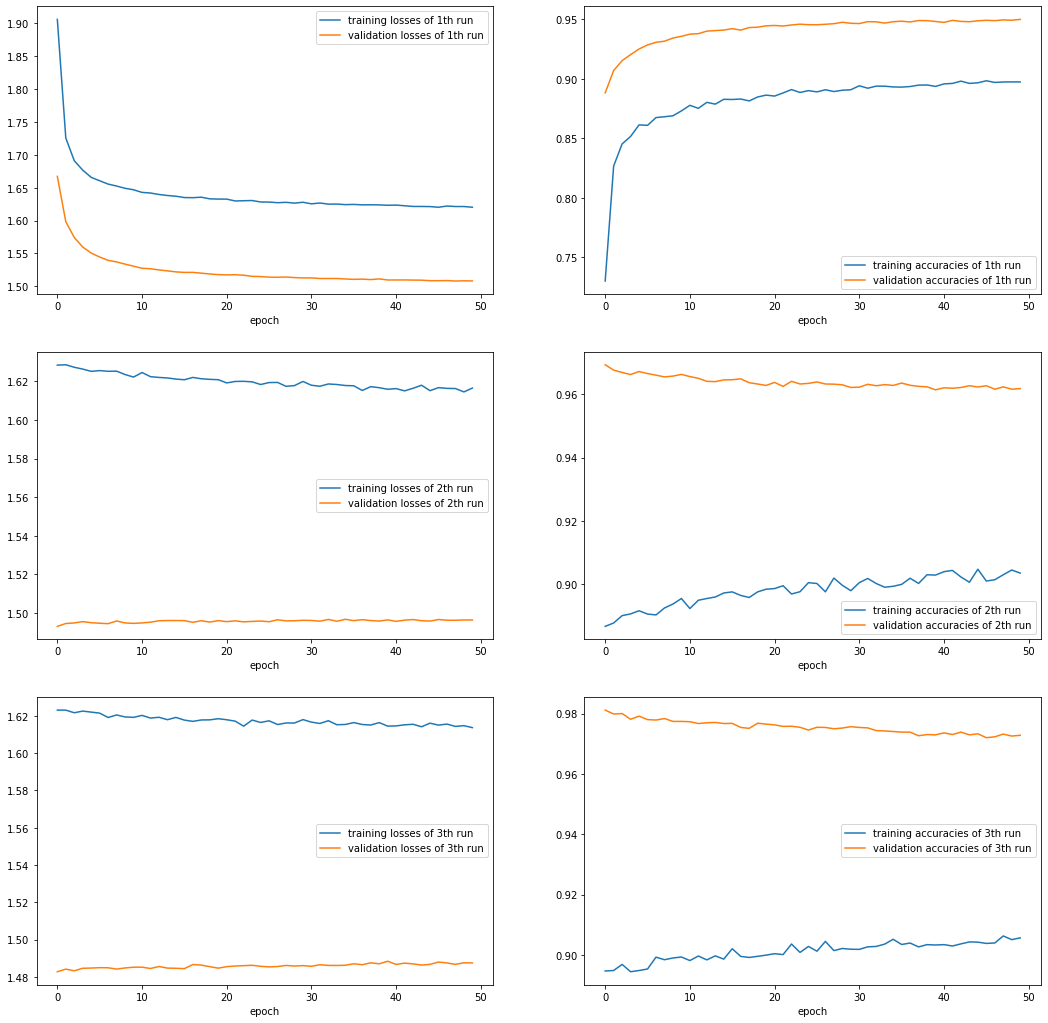

In [32]:
print(trainer_2a.evaluate(test_x, test_y))

fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_results_2a)):
    axes[i][0].plot(training_results_2a[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_results_2a[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_results_2a[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_results_2a[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

The validation accuracy is higher than the training accuracy, suggesting that the model may be underfitting. However, despite this improvement in validation accuracy, the test accuracy did not improve compared to the model of 1d.

#### b:

In [33]:
class MLPNet_2B(nn.Module):
    def __init__(self):
        super(MLPNet_2B, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(1024, 50),
            nn.Linear(50, 10)])
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
                        
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.fc[-1](x))
        return x
    
model_2b = MLPNet_2B()

trainer_2b = Trainer(model=model_2b, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_2b = []
for train_index, val_index in kf.split(train_x, train_y):
    X_train, X_val = train_x[train_index], train_x[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_2b.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=True, silent=False)
    training_results_2b.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:39,  1.23it/s]

Epoch 1/50 - Loss: 1.832 - Acc: 0.802
              Val_loss: 1.654 - Val_acc: 0.889


 22%|██▏       | 11/50 [00:07<00:28,  1.39it/s]

Epoch 11/50 - Loss: 1.560 - Acc: 0.953
              Val_loss: 1.520 - Val_acc: 0.941


 42%|████▏     | 21/50 [00:14<00:20,  1.43it/s]

Epoch 21/50 - Loss: 1.580 - Acc: 0.968
              Val_loss: 1.510 - Val_acc: 0.951


 62%|██████▏   | 31/50 [00:21<00:14,  1.29it/s]

Epoch 31/50 - Loss: 1.613 - Acc: 0.976
              Val_loss: 1.507 - Val_acc: 0.953


 82%|████████▏ | 41/50 [00:28<00:06,  1.39it/s]

Epoch 41/50 - Loss: 1.650 - Acc: 0.981
              Val_loss: 1.508 - Val_acc: 0.955


func:'train'  took: 35.2502 sec


  2%|▏         | 1/50 [00:00<00:40,  1.22it/s]

Epoch 1/50 - Loss: 1.706 - Acc: 0.969
              Val_loss: 1.481 - Val_acc: 0.979


 22%|██▏       | 11/50 [00:07<00:28,  1.38it/s]

Epoch 11/50 - Loss: 1.720 - Acc: 0.980
              Val_loss: 1.483 - Val_acc: 0.978


 42%|████▏     | 21/50 [00:14<00:20,  1.42it/s]

Epoch 21/50 - Loss: 1.748 - Acc: 0.983
              Val_loss: 1.486 - Val_acc: 0.977


 62%|██████▏   | 31/50 [00:23<00:14,  1.30it/s]

Epoch 31/50 - Loss: 1.782 - Acc: 0.986
              Val_loss: 1.489 - Val_acc: 0.974


 82%|████████▏ | 41/50 [00:30<00:06,  1.44it/s]

Epoch 41/50 - Loss: 1.819 - Acc: 0.987
              Val_loss: 1.491 - Val_acc: 0.973


func:'train'  took: 36.4361 sec


  2%|▏         | 1/50 [00:00<00:45,  1.07it/s]

Epoch 1/50 - Loss: 1.873 - Acc: 0.978
              Val_loss: 1.472 - Val_acc: 0.988


 22%|██▏       | 11/50 [00:08<00:28,  1.38it/s]

Epoch 11/50 - Loss: 1.890 - Acc: 0.986
              Val_loss: 1.473 - Val_acc: 0.988


 42%|████▏     | 21/50 [00:15<00:23,  1.22it/s]

Epoch 21/50 - Loss: 1.918 - Acc: 0.987
              Val_loss: 1.476 - Val_acc: 0.986


 62%|██████▏   | 31/50 [00:22<00:12,  1.51it/s]

Epoch 31/50 - Loss: 1.952 - Acc: 0.988
              Val_loss: 1.478 - Val_acc: 0.985


 82%|████████▏ | 41/50 [00:28<00:05,  1.60it/s]

Epoch 41/50 - Loss: 1.988 - Acc: 0.988
              Val_loss: 1.479 - Val_acc: 0.984


func:'train'  took: 34.4421 sec


In [34]:
print(trainer_2b.evaluate(test_x, test_y))

Accuracy: 0.965
(1.5013657089233396, 0.9647000000000001)


The loss function used for the training of 2b is "L2", while "L1" was used for the validation runs. This difference in loss functions between the training and validation runs can cause inconsistencies in the plotted data, potentially leading to incorrect conclusions.

Furthermore, although the accuracy of 2b did not improve compared to 1d, the validation accuracy did increase to 98.3%. This suggests that the model may be overfitting to the training data, but is generalizing better to the validation data.

#### c:

In [35]:
pca = PCA(0.99)
train_x_pca = pca.fit_transform(train_x.reshape(60000, 1024))
test_x_pca = pca.transform(test_x.reshape(10000, 1024))
print("train_x shape after PCA transformation: ", train_x_pca.shape)
print("test_x shape after PCA transformation: ", test_x_pca.shape)

train_x shape after PCA transformation:  (60000, 331)
test_x shape after PCA transformation:  (10000, 331)


In [36]:
class MLPNet_2C(nn.Module):
    def __init__(self):
        super(MLPNet_2C, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(331, 50),
            nn.Linear(50, 10)])
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
                        
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.fc[-1](x))
        return x
    
model_2c = MLPNet_2C()

trainer_2c = Trainer(model=model_2c, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_2c = []
for train_index, val_index in kf.split(train_x_pca, train_y):
    X_train, X_val = train_x_pca[train_index], train_x_pca[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_2c.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=False, silent=False)
    training_results_2c.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:19,  2.51it/s]

Epoch 1/50 - Loss: 1.932 - Acc: 0.739
              Val_loss: 1.687 - Val_acc: 0.888


 22%|██▏       | 11/50 [00:04<00:16,  2.38it/s]

Epoch 11/50 - Loss: 1.518 - Acc: 0.947
              Val_loss: 1.532 - Val_acc: 0.932


 42%|████▏     | 21/50 [00:08<00:12,  2.33it/s]

Epoch 21/50 - Loss: 1.498 - Acc: 0.963
              Val_loss: 1.521 - Val_acc: 0.941


 62%|██████▏   | 31/50 [00:12<00:08,  2.37it/s]

Epoch 31/50 - Loss: 1.488 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.945


 82%|████████▏ | 41/50 [00:16<00:03,  2.29it/s]

Epoch 41/50 - Loss: 1.483 - Acc: 0.976
              Val_loss: 1.518 - Val_acc: 0.946


func:'train'  took: 21.1619 sec


  2%|▏         | 1/50 [00:00<00:21,  2.25it/s]

Epoch 1/50 - Loss: 1.497 - Acc: 0.964
              Val_loss: 1.483 - Val_acc: 0.976


 22%|██▏       | 11/50 [00:05<00:19,  2.04it/s]

Epoch 11/50 - Loss: 1.482 - Acc: 0.976
              Val_loss: 1.488 - Val_acc: 0.973


 42%|████▏     | 21/50 [00:09<00:12,  2.28it/s]

Epoch 21/50 - Loss: 1.479 - Acc: 0.980
              Val_loss: 1.494 - Val_acc: 0.970


 62%|██████▏   | 31/50 [00:13<00:08,  2.24it/s]

Epoch 31/50 - Loss: 1.477 - Acc: 0.981
              Val_loss: 1.497 - Val_acc: 0.967


 82%|████████▏ | 41/50 [00:17<00:03,  2.67it/s]

Epoch 41/50 - Loss: 1.475 - Acc: 0.982
              Val_loss: 1.500 - Val_acc: 0.966


func:'train'  took: 21.2313 sec


  2%|▏         | 1/50 [00:00<00:19,  2.50it/s]

Epoch 1/50 - Loss: 1.489 - Acc: 0.972
              Val_loss: 1.474 - Val_acc: 0.986


 22%|██▏       | 11/50 [00:04<00:15,  2.59it/s]

Epoch 11/50 - Loss: 1.479 - Acc: 0.979
              Val_loss: 1.475 - Val_acc: 0.986


 42%|████▏     | 21/50 [00:08<00:12,  2.29it/s]

Epoch 21/50 - Loss: 1.477 - Acc: 0.980
              Val_loss: 1.479 - Val_acc: 0.984


 62%|██████▏   | 31/50 [00:12<00:08,  2.27it/s]

Epoch 31/50 - Loss: 1.476 - Acc: 0.981
              Val_loss: 1.483 - Val_acc: 0.981


 82%|████████▏ | 41/50 [00:17<00:03,  2.32it/s]

Epoch 41/50 - Loss: 1.475 - Acc: 0.982
              Val_loss: 1.485 - Val_acc: 0.979


func:'train'  took: 21.1290 sec


Accuracy: 0.957
(1.5111580398559574, 0.9573000000000003)


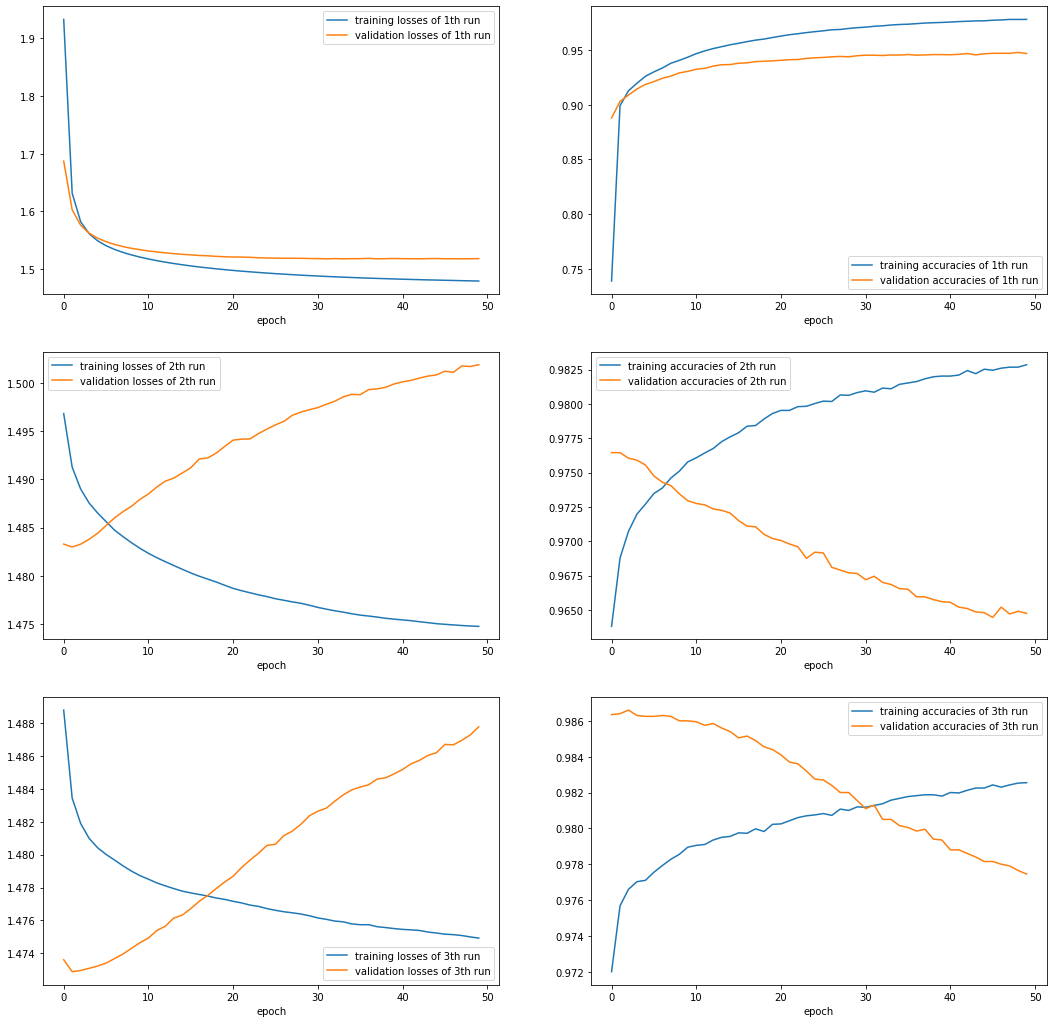

In [37]:
print(trainer_2c.evaluate(test_x_pca, test_y))

fig, axes = plt.subplots(3, 2, figsize=(18,18))
for i in range(len(training_results_2c)):
    axes[i][0].plot(training_results_2c[i]["losses"], label = f"training losses of {i+1}th run")
    axes[i][0].plot(training_results_2c[i]["val_losses"], label = f"validation losses of {i+1}th run")
    axes[i][0].legend()
    axes[i][0].set_xlabel('epoch')
    axes[i][1].plot(training_results_2c[i]["accuracies"], label = f"training accuracies of {i+1}th run")
    axes[i][1].plot(training_results_2c[i]["val_accuracies"], label = f"validation accuracies of {i+1}th run")
    axes[i][1].legend()
    axes[i][1].set_xlabel('epoch') 

The performance of model 2c, which uses the PCA method for input dimensionality reduction, is similar to that of model 1d. However, due to the smaller input size, model 2c experiences more serious overfitting, as evidenced by the drop in validation accuracy starting at the 2nd run.

Despite the overfitting issue, model 2c with PCA is faster than 1d and still performs similarly. Therefore, PCA is a useful transformational method to consider when dealing with large input sizes.

#### d:

Test Accuracy:

2a: 0.959

2b: 0.965

So, we might choose 2b (L2 Regularization) for the following test.

In [38]:
class MLPNet_2D(nn.Module):
    def __init__(self):
        super(MLPNet_2D, self).__init__()
        self.fc = nn.ModuleList([nn.Linear(331, 50),
            nn.Linear(50, 10)])
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        for i in range(1):
            x = self.fc[i](x)
                        
            x = self.activation(x)
        
        x = nn.Sigmoid()(self.fc[-1](x))
        return x
    
model_2d = MLPNet_2D()

trainer_2d = Trainer(model=model_2d, optimizer_type="adam", learning_rate=2e-3, epoch=50, batch_size=128)

kf = KFold(n_splits=3, shuffle=True, random_state=1)

training_results_2d = []
for train_index, val_index in kf.split(train_x_pca, train_y):
    X_train, X_val = train_x_pca[train_index], train_x_pca[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]

    training_result = trainer_2d.train(X_train, y_train, X_val, y_val, \
                     early_stop=False, l2=True, silent=False)
    training_results_2d.append(training_result)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-19-5a13996b4694>:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float)
<ipython-input-19-5a13996b4694>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.int64)
  2%|▏         | 1/50 [00:00<00:25,  1.90it/s]

Epoch 1/50 - Loss: 1.938 - Acc: 0.737
              Val_loss: 1.690 - Val_acc: 0.884


 22%|██▏       | 11/50 [00:05<00:18,  2.08it/s]

Epoch 11/50 - Loss: 1.543 - Acc: 0.946
              Val_loss: 1.531 - Val_acc: 0.932


 42%|████▏     | 21/50 [00:10<00:15,  1.93it/s]

Epoch 21/50 - Loss: 1.545 - Acc: 0.962
              Val_loss: 1.521 - Val_acc: 0.940


 62%|██████▏   | 31/50 [00:15<00:08,  2.28it/s]

Epoch 31/50 - Loss: 1.557 - Acc: 0.971
              Val_loss: 1.518 - Val_acc: 0.944


 82%|████████▏ | 41/50 [00:19<00:03,  2.40it/s]

Epoch 41/50 - Loss: 1.575 - Acc: 0.975
              Val_loss: 1.518 - Val_acc: 0.945


func:'train'  took: 23.5094 sec


  2%|▏         | 1/50 [00:00<00:20,  2.44it/s]

Epoch 1/50 - Loss: 1.612 - Acc: 0.963
              Val_loss: 1.483 - Val_acc: 0.976


 22%|██▏       | 11/50 [00:04<00:15,  2.45it/s]

Epoch 11/50 - Loss: 1.609 - Acc: 0.976
              Val_loss: 1.488 - Val_acc: 0.973


 42%|████▏     | 21/50 [00:08<00:12,  2.39it/s]

Epoch 21/50 - Loss: 1.624 - Acc: 0.979
              Val_loss: 1.494 - Val_acc: 0.970


 62%|██████▏   | 31/50 [00:13<00:09,  2.00it/s]

Epoch 31/50 - Loss: 1.643 - Acc: 0.981
              Val_loss: 1.498 - Val_acc: 0.966


 82%|████████▏ | 41/50 [00:18<00:04,  1.99it/s]

Epoch 41/50 - Loss: 1.664 - Acc: 0.982
              Val_loss: 1.500 - Val_acc: 0.965


func:'train'  took: 22.1159 sec


  2%|▏         | 1/50 [00:00<00:20,  2.40it/s]

Epoch 1/50 - Loss: 1.701 - Acc: 0.972
              Val_loss: 1.473 - Val_acc: 0.986


 22%|██▏       | 11/50 [00:04<00:15,  2.45it/s]

Epoch 11/50 - Loss: 1.700 - Acc: 0.979
              Val_loss: 1.475 - Val_acc: 0.985


 42%|████▏     | 21/50 [00:08<00:11,  2.50it/s]

Epoch 21/50 - Loss: 1.714 - Acc: 0.981
              Val_loss: 1.478 - Val_acc: 0.984


 62%|██████▏   | 31/50 [00:12<00:08,  2.23it/s]

Epoch 31/50 - Loss: 1.731 - Acc: 0.982
              Val_loss: 1.482 - Val_acc: 0.981


 82%|████████▏ | 41/50 [00:17<00:03,  2.30it/s]

Epoch 41/50 - Loss: 1.750 - Acc: 0.983
              Val_loss: 1.485 - Val_acc: 0.979


func:'train'  took: 21.7592 sec


In [39]:
print(trainer_2d.evaluate(test_x_pca, test_y))

Accuracy: 0.955
(1.513784618759155, 0.9551000000000005)


When the input size is small, it appears that L2 regularization did not have a significant impact on the test accuracy.

|       Training method      | Training Acc. | Validation Acc. |    Testing Acc.    | Time per Train (s) |
|:--------------------------:|:-------------:|:---------------:|:------------------:|:------------------:|
|  1C: hidden-layer-size = 3 |     0.561     |      0.559      | 0.5501999999999999 |       14.0486      |
| 1D: hidden-layer-size = 50 |     0.987     |      0.985      | 0.9650000000000003 |       27.3452      |
|   2A: 1D + dropout(0.15)   |     0.903     |      0.974      | 0.9594000000000006 |       30.1464      |
|   2B: 1D + L2-Regulation   |     0.988     |      0.984      | 0.9647000000000001 |       34.4421      |
|        2C: 1D + PCA        |     0.982     |      0.979      | 0.9573000000000003 |       21.1290      |
|      2D: 1D + PCA + L2     |     0.983     |      0.979      | 0.9551000000000005 |       21.7592      |

The table above shows that when the input size is large (1024), adding L2 regularization can improve the performance of the model by preventing overfitting. However, when the input size is reduced to 331 using PCA, applying L2 regularization during training can actually worsen the model's performance.

For future assignments, it is important to select the appropriate training method based on the input size, as using the wrong method can result in poorer performance than the original model.